# Psychology-Based Tendencies
This notebook demonstrates some of the psychology-based tendencies mentioned in Poor Charlie's Almanack. It also demonstrates basic methods of machine learning.

### Reward and punishment superresponse tendency
I've decided to illustrate the power of incentives with an example from the insurance industry.

>A business practice of extended declines in revenue is virtually *unthinkable* for any public company, especially when billions are readily available if they are only willing to cut prices to industry levels.
>
>The incentives in most American businesses are that:
> 1. No CEO enjoys reporting to shareholders that business not only contracted last year but will continue to drop
> 2. Employees have a natural tendency to save their own skins, fearing that a shrinking business will lead to layoffs and hence, rationalizing inadequate pricing
>
> **National Indemnity of Berkshire Hathaway promised its workforce that _no one will be fired due to declining volume, however severe the contraction_**, reasoning that *"the business can live with excess overhead but can't live with underpriced business and the breakdown in underwriting discipline that accompanies it."*  
>
> The underwriting results suggest that:
> - The decision was rational  
> - The power of incentives and disincentives should not be underestimated

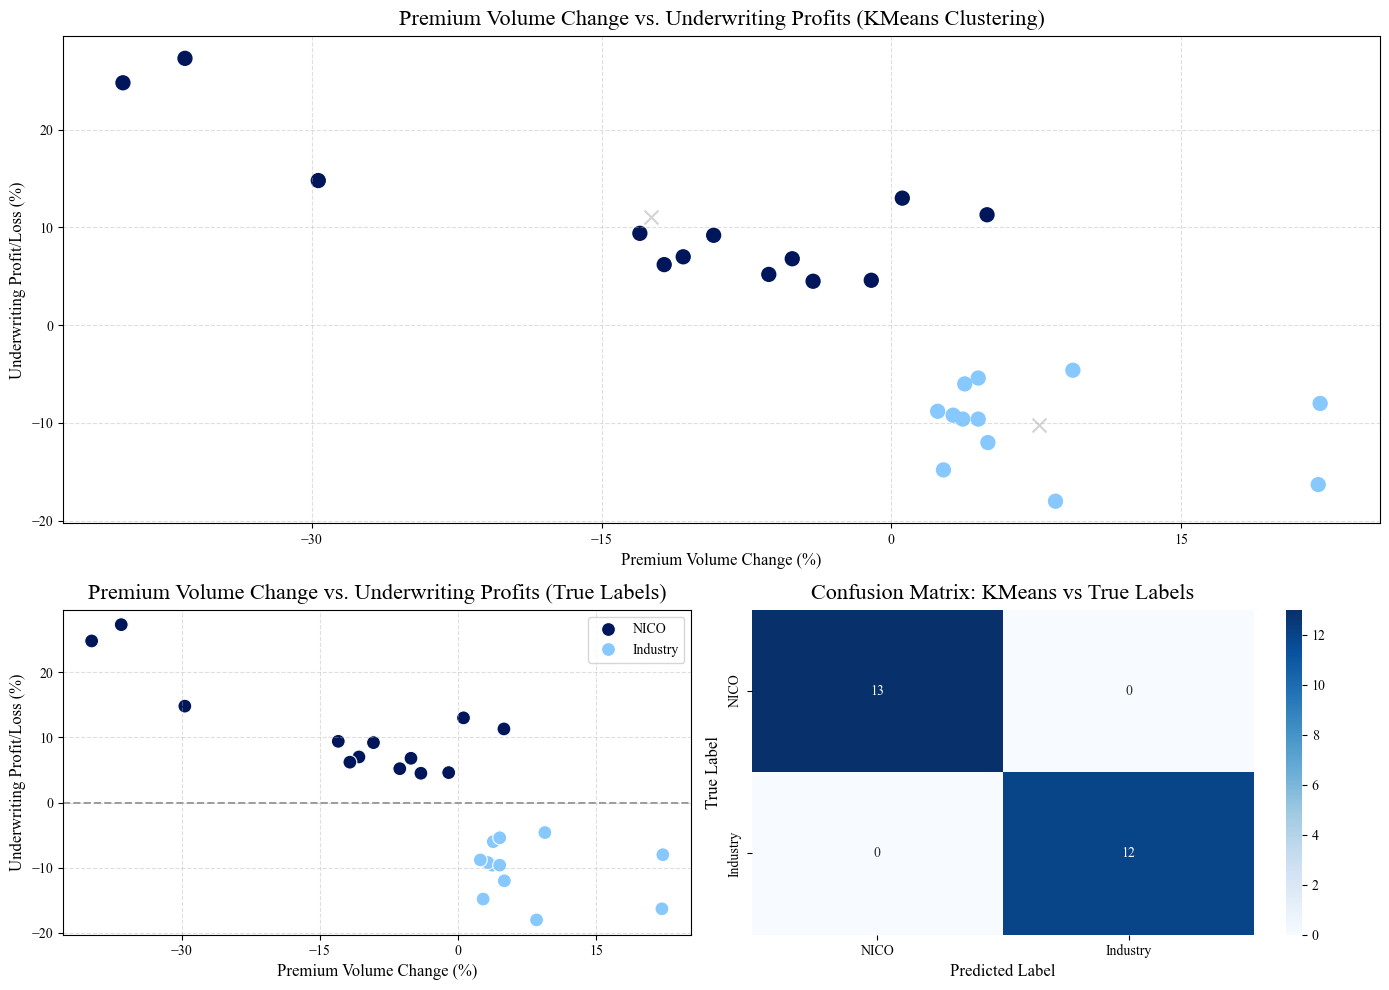

In [86]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

df_nico = pd.read_csv("data/insurance_nico.csv").assign(Source="NICO")
df_industry = pd.read_csv("data/insurance_industry.csv").assign(Source="Industry")
df_nico = df_nico.rename(columns={"Written Premium ($M)": "premium_volume", "Underwriting Profit/Loss (%)": "underwriting_profit"})
df_nico = df_nico.query("1986 <= Year <= 1999").assign(premium_change_pct=lambda d: d["premium_volume"].pct_change() * 100)
df_nico = df_nico.drop(columns=["premium_volume"])
df_combined = pd.concat([df_nico, df_industry], ignore_index=True).dropna()

df_kmeans = df_combined[["premium_change_pct", "underwriting_profit"]].copy()
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_kmeans)
y_kmeans = kmeans.predict(df_kmeans)
centers = kmeans.cluster_centers_
df_combined["cluster"] = y_kmeans

colors = ["#00165b", "#87c8ff"]
cluster_colors = [colors[label] for label in y_kmeans]
ct = pd.crosstab(df_combined["cluster"], df_combined["Source"])
cluster_to_label = {cl: ct.loc[cl].idxmax() for cl in ct.index}
df_combined["predicted_label"] = df_combined["cluster"].map(cluster_to_label)
cm = confusion_matrix(df_combined["Source"], df_combined["predicted_label"], labels=["NICO", "Industry"])

mpl.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1.5, 1])
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.scatter(df_kmeans["premium_change_pct"], df_kmeans["underwriting_profit"], c=cluster_colors, s=100)
ax1.scatter(centers[:, 0], centers[:, 1], c="#a7a8aa", s=100, alpha=0.5, marker='x')
ax1.set_xlabel("Premium Volume Change (%)", fontsize=12)
ax1.set_ylabel("Underwriting Profit/Loss (%)", fontsize=12)
ax1.set_title("Premium Volume Change vs. Underwriting Profits (KMeans Clustering)", fontsize=16, pad=8)
ax1.grid(True, linestyle="--", alpha=0.4)

sns.scatterplot(data=df_combined, x="premium_change_pct", y="underwriting_profit", hue="Source", palette={"NICO": "#00165b", "Industry": "#87c8ff"}, s=100, ax=ax2)
ax2.set_xlabel("Premium Volume Change (%)", fontsize=12)
ax2.set_ylabel("Underwriting Profit/Loss (%)", fontsize=12)
ax2.set_title("Premium Volume Change vs. Underwriting Profits (True Labels)", fontsize=16, pad=8)
ax2.grid(True, linestyle="--", alpha=0.4)
ax2.axhline(0, color="black", linewidth=1.4, alpha=0.4, linestyle="--", zorder=0)
ax2.legend(loc="best")

sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["NICO", "Industry"], yticklabels=["NICO", "Industry"], ax=ax3)
ax3.set_xlabel("Predicted Label", fontsize=12)
ax3.set_ylabel("True Label", fontsize=12)
ax3.set_title("Confusion Matrix: KMeans vs True Labels", fontsize=16, pad=8)

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6))
fig.tight_layout()
plt.show()

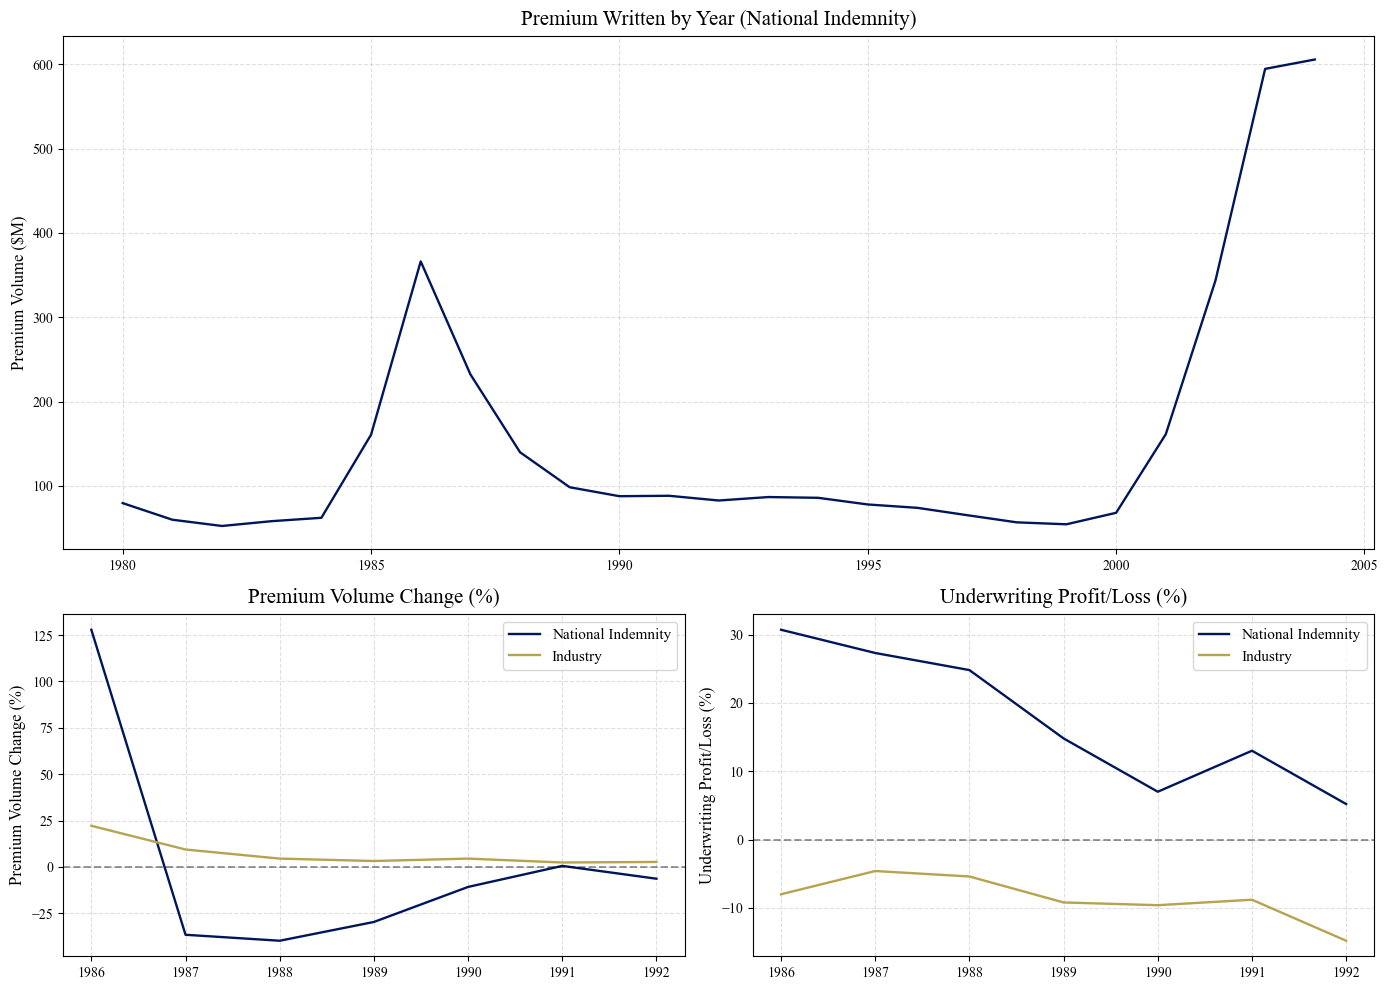

In [87]:
df_nico_full = pd.read_csv("data/insurance_nico.csv").assign(Source="NICO")
df_nico_full = df_nico_full.rename(columns={"Written Premium ($M)": "premium_volume", "Underwriting Profit/Loss (%)": "underwriting_profit_nico"})
df_nico_full = df_nico_full.assign(premium_change_pct_nico=lambda d: d["premium_volume"].pct_change() * 100)

df_nico_86_92 = df_nico_full.query("1986 <= Year <= 1992")
growth_compare = pd.merge(df_nico_86_92[["Year", "premium_change_pct_nico"]], df_industry[["Year", "premium_change_pct"]], on="Year")
profit_compare = pd.merge(df_nico_86_92[["Year", "underwriting_profit_nico"]], df_industry[["Year", "underwriting_profit"]], on="Year")

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1.5, 1])
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(df_nico_full["Year"], df_nico_full["premium_volume"], color="#00165b", linewidth=1.7)
ax1.set_title("Premium Written by Year (National Indemnity)", fontsize=15, pad=8)
ax1.set_xlabel("")
ax1.set_ylabel("Premium Volume ($M)", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.4)

ax2.plot(growth_compare["Year"], growth_compare["premium_change_pct_nico"], color="#00165b", linewidth=1.7)
ax2.plot(growth_compare["Year"], growth_compare["premium_change_pct"], color="#b5a34f", linewidth=1.7)
ax2.set_title("Premium Volume Change (%)", fontsize=15, pad=8)
ax2.set_xlabel("")
ax2.set_ylabel("Premium Volume Change (%)", fontsize=12)
ax2.legend(["National Indemnity", "Industry"], fontsize=11)
ax2.set_xticks(growth_compare["Year"])
ax2.axhline(0, color="black", linewidth=1.4, linestyle="--", alpha=0.4)
ax2.grid(True, linestyle="--", alpha=0.4)

ax3.plot(profit_compare["Year"], profit_compare["underwriting_profit_nico"], color="#00165b", linewidth=1.7)
ax3.plot(profit_compare["Year"], profit_compare["underwriting_profit"],  color="#b5a34f", linewidth=1.7)
ax3.set_title("Underwriting Profit/Loss (%)", fontsize=15, pad=8)
ax3.set_xlabel("")
ax3.set_ylabel("Underwriting Profit/Loss (%)", fontsize=12)
ax3.legend(["National Indemnity", "Industry"], fontsize=11)
ax3.axhline(0, color="black", linewidth=1.4, linestyle="--", alpha=0.4)
ax3.set_xticks(growth_compare["Year"])
ax3.grid(True, linestyle="--", alpha=0.4)
fig.tight_layout()
plt.show()

### Doubt-avoidance tendency

I've decided to illustrate doubt-avoidance tendency with an example from the credit card industry.

>Analysts often note that American Express operates a closed-loop network, which results in higher transaction volume per card and greater revenue per transaction compared to Visa and Mastercard. A common assumption, driven by doubt-avoidance tendency, is that an equal percentage increase in cards-in-force should translate into a larger percentage increase in Amex’s net income than for its competitors. As is suggested below, this is not true.
>
>In fact, avoiding this tendency makes it clear that Amex must expense a larger share of its revenue to expenses (rewards, customer service, and so forth) due to its closed-loop model.

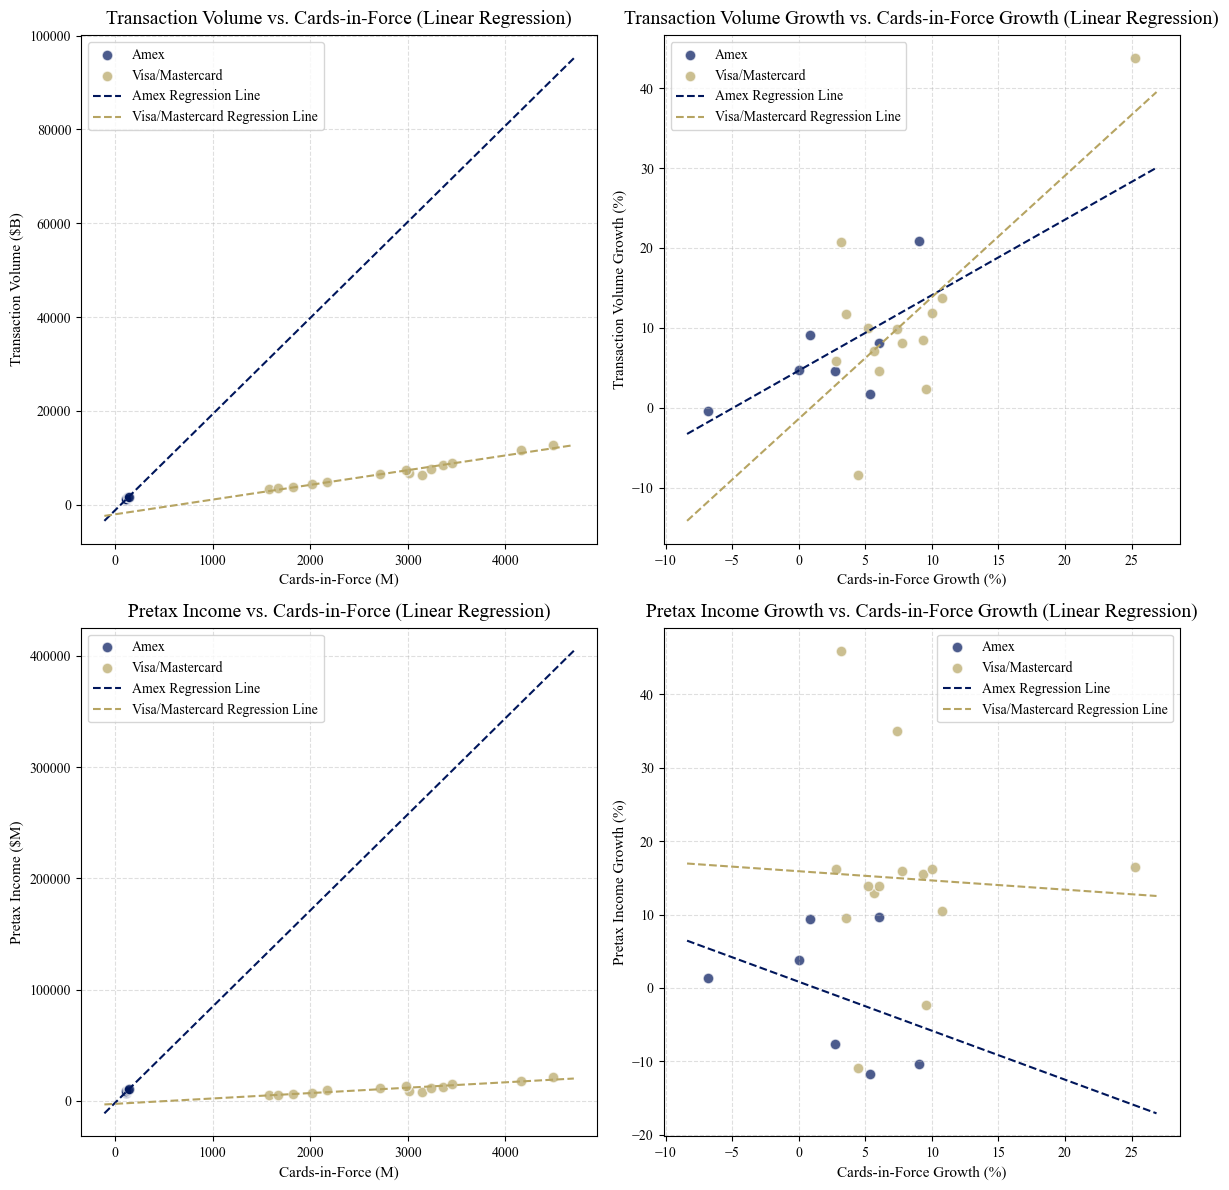

In [88]:
from sklearn.linear_model import LinearRegression

files = {"Amex": "american_express.csv", "Visa": "visa.csv", "Mastercard": "mastercard.csv"}
growth_map = {"payments_volume_b": "payments_volume_growth", "cards_in_force_m": "cards_in_force_growth", "pretax_income_m": "pretax_income_growth"}
dfs = []
for company, fname in files.items():
    df = (pd.read_csv(f"data/{fname}").sort_values("year").assign(company=company))
    for src, tgt in growth_map.items():
        df[tgt] = df[src].pct_change().mul(100.0)
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True).dropna().reset_index(drop=True)
df_filt = df_all[~df_all["year"].isin([2020, 2021])]

colors = {"Amex": {"members": ["Amex"], "color": "#00165b"}, "Visa/Mastercard": {"members": ["Visa", "Mastercard"], "color": "#b6a462"}}
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
def draw_panel(ax, y_var, x_var, title, xlabel, ylabel):
    df_plot = df_filt.dropna(subset=[x_var, y_var])
    sc_amex = df_plot[df_plot["company"] == "Amex"]
    ax.scatter(sc_amex[x_var].to_numpy(), sc_amex[y_var].to_numpy(),
               alpha=0.7, label="Amex", color=colors["Amex"]["color"], edgecolor="white", s=60)
    sc_vm = df_plot[df_plot["company"].isin(colors["Visa/Mastercard"]["members"])]
    ax.scatter(sc_vm[x_var].to_numpy(), sc_vm[y_var].to_numpy(), alpha=0.7, label="Visa/Mastercard", color=colors["Visa/Mastercard"]["color"], edgecolor="white", s=60)
    x_lo, x_hi = ax.get_xlim()
    for gname, meta in colors.items():
        sg = df_plot[df_plot["company"].isin(meta["members"])]
        X = sg[[x_var]].to_numpy()
        y = sg[y_var].to_numpy()
        model = LinearRegression().fit(X, y)
        x_grid = np.linspace(x_lo, x_hi, 300).reshape(-1, 1)
        y_grid = model.predict(x_grid)
        ax.plot(x_grid, y_grid, linestyle="--", linewidth=1.5, color=meta["color"], label=f"{gname} Regression Line")
    ax.set_title(title, fontsize=14, pad=8)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="best", fontsize=10)

draw_panel(
    axes[0, 0], y_var="payments_volume_b", x_var="cards_in_force_m",
    title="Transaction Volume vs. Cards-in-Force (Linear Regression)", xlabel="Cards-in-Force (M)", ylabel="Transaction Volume ($B)"
)
draw_panel(
    axes[0, 1], y_var="payments_volume_growth", x_var="cards_in_force_growth",
    title="Transaction Volume Growth vs. Cards-in-Force Growth (Linear Regression)", xlabel="Cards-in-Force Growth (%)", ylabel="Transaction Volume Growth (%)"
)
draw_panel(
    axes[1, 0], y_var="pretax_income_m", x_var="cards_in_force_m",
    title="Pretax Income vs. Cards-in-Force (Linear Regression)", xlabel="Cards-in-Force (M)", ylabel="Pretax Income ($M)"
)
draw_panel(
    axes[1, 1], y_var="pretax_income_growth", x_var="cards_in_force_growth",
    title="Pretax Income Growth vs. Cards-in-Force Growth (Linear Regression)", xlabel="Cards-in-Force Growth (%)", ylabel="Pretax Income Growth (%)"
)
fig.tight_layout()
plt.show()